# Initialization

In [1]:
import numpy as np
from preprocessing import parse_annotation
from frontend import YOLO
import json
import os


%matplotlib inline

/Users/mikaelvo/PyEnvs/coreml_convert/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
with open('config_mobilenet.json') as config_buffer:    
    config = json.loads(config_buffer.read())
print(json.dumps(config, indent=2))

{
  "model": {
    "labels": [
      "white_dude", 
      "black_dude"
    ], 
    "input_size": 224, 
    "max_box_per_image": 10, 
    "architecture": "MobileNet", 
    "anchors": [
      0.3, 
      0.3, 
      1.975, 
      1.975, 
      3.65, 
      3.65, 
      5.325, 
      5.325, 
      7.0, 
      7.0
    ]
  }, 
  "train": {
    "warmup_epochs": 0, 
    "no_object_scale": 1.0, 
    "saved_weights_name": "traq_object_detector.h5", 
    "debug": false, 
    "learning_rate": 0.0001, 
    "coord_scale": 1.0, 
    "batch_size": 32, 
    "class_scale": 1.0, 
    "train_image_folder": "./training/images/", 
    "object_scale": 5.0, 
    "train_annot_folder": "./training/annotations/", 
    "pretrained_weights": "traq_object_detector.h5", 
    "nb_epoch": 50, 
    "train_times": 10
  }, 
  "valid": {
    "valid_annot_folder": "", 
    "valid_image_folder": "", 
    "valid_times": 1
  }
}


# Construct the network

In [3]:
model = YOLO(architecture        = config['model']['architecture'],
            input_size          = config['model']['input_size'], 
            labels              = config['model']['labels'], 
            max_box_per_image   = config['model']['max_box_per_image'],
            anchors             = config['model']['anchors'])


(7, 7)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
model_1 (Model)                  (None, 7, 7, 1024)    3228864     input_1[0][0]                    
____________________________________________________________________________________________________
conv_23 (Conv2D)                 (None, 7, 7, 35)      35875       model_1[1][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 7, 7, 5, 7)    0           conv_23[0][0]                    
____________________________________________________________________________________

# Load pretrained weights

**Load the trained weights**

In [5]:
if os.path.exists(config['train']['pretrained_weights']):
    print("Loading pre-trained weights in", config['train']['pretrained_weights'])
    model.load_weights(config['train']['pretrained_weights'])

('Loading pre-trained weights in', u'traq_object_detector.h5')


# Perform training

**Loss function**

$$\begin{multline}
\lambda_\textbf{coord}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
     L_{ij}^{\text{obj}}
            \left[
            \left(
                x_i - \hat{x}_i
            \right)^2 +
            \left(
                y_i - \hat{y}_i
            \right)^2
            \right]
\hfill 
+ \lambda_\textbf{coord} 
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
         L_{ij}^{\text{obj}}
         \left[
        \left(
            \sqrt{w_i} - \sqrt{\hat{w}_i}
        \right)^2 +
        \left(
            \sqrt{h_i} - \sqrt{\hat{h}_i}
        \right)^2
        \right]
\\
+ \sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
        L_{ij}^{\text{obj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
+ \lambda_\textrm{noobj}
\sum_{i = 0}^{S^2}
    \sum_{j = 0}^{B}
    L_{ij}^{\text{noobj}}
        \left(
            C_i - \hat{C}_i
        \right)^2
+ \sum_{i = 0}^{S^2}
L_i^{\text{obj}}
    \sum_{c \in \textrm{classes}}
        \left(
            p_i(c) - \hat{p}_i(c)
        \right)^2
\end{multline}$$

In [ ]:
def custom_loss(y_true, y_pred):
    mask_shape = tf.shape(y_true)[:4]
    
    cell_x = tf.to_float(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)))
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))

    cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, 5, 1])
    
    coord_mask = tf.zeros(mask_shape)
    conf_mask  = tf.zeros(mask_shape)
    class_mask = tf.zeros(mask_shape)
    
    seen = tf.Variable(0.)
    total_recall = tf.Variable(0.)
    
    """
    Adjust prediction
    """
    ### adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    
    ### adjust w and h
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    
    ### adjust confidence
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    
    ### adjust class probabilities
    pred_box_class = y_pred[..., 5:]
    
    """
    Adjust ground truth
    """
    ### adjust x and y
    true_box_xy = y_true[..., 0:2] # relative position to the containing cell
    
    ### adjust w and h
    true_box_wh = y_true[..., 2:4] # number of cells accross, horizontally and vertically
    
    ### adjust confidence
    true_wh_half = true_box_wh / 2.
    true_mins    = true_box_xy - true_wh_half
    true_maxes   = true_box_xy + true_wh_half
    
    pred_wh_half = pred_box_wh / 2.
    pred_mins    = pred_box_xy - pred_wh_half
    pred_maxes   = pred_box_xy + pred_wh_half       
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_box_wh[..., 0] * true_box_wh[..., 1]
    pred_areas = pred_box_wh[..., 0] * pred_box_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)
    
    true_box_conf = iou_scores * y_true[..., 4]
    
    ### adjust class probabilities
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    
    """
    Determine the masks
    """
    ### coordinate mask: simply the position of the ground truth boxes (the predictors)
    coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * COORD_SCALE
    
    ### confidence mask: penelize predictors + penalize boxes with low IOU
    # penalize the confidence of the boxes, which have IOU with some ground truth box < 0.6
    true_xy = true_boxes[..., 0:2]
    true_wh = true_boxes[..., 2:4]
    
    true_wh_half = true_wh / 2.
    true_mins    = true_xy - true_wh_half
    true_maxes   = true_xy + true_wh_half
    
    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)
    
    pred_wh_half = pred_wh / 2.
    pred_mins    = pred_xy - pred_wh_half
    pred_maxes   = pred_xy + pred_wh_half    
    
    intersect_mins  = tf.maximum(pred_mins,  true_mins)
    intersect_maxes = tf.minimum(pred_maxes, true_maxes)
    intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
    true_areas = true_wh[..., 0] * true_wh[..., 1]
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores  = tf.truediv(intersect_areas, union_areas)

    best_ious = tf.reduce_max(iou_scores, axis=4)
    conf_mask = conf_mask + tf.to_float(best_ious < 0.6) * (1 - y_true[..., 4]) * NO_OBJECT_SCALE
    
    # penalize the confidence of the boxes, which are reponsible for corresponding ground truth box
    conf_mask = conf_mask + y_true[..., 4] * OBJECT_SCALE
    
    ### class mask: simply the position of the ground truth boxes (the predictors)
    class_mask = y_true[..., 4] * tf.gather(CLASS_WEIGHTS, true_box_class) * CLASS_SCALE       
    
    """
    Warm-up training
    """
    no_boxes_mask = tf.to_float(coord_mask < COORD_SCALE/2.)
    seen = tf.assign_add(seen, 1.)
    
    true_box_xy, true_box_wh, coord_mask = tf.cond(tf.less(seen, WARM_UP_BATCHES), 
                          lambda: [true_box_xy + (0.5 + cell_grid) * no_boxes_mask, 
                                   true_box_wh + tf.ones_like(true_box_wh) * np.reshape(ANCHORS, [1,1,1,BOX,2]) * no_boxes_mask, 
                                   tf.ones_like(coord_mask)],
                          lambda: [true_box_xy, 
                                   true_box_wh,
                                   coord_mask])
    
    """
    Finalize the loss
    """
    nb_coord_box = tf.reduce_sum(tf.to_float(coord_mask > 0.0))
    nb_conf_box  = tf.reduce_sum(tf.to_float(conf_mask  > 0.0))
    nb_class_box = tf.reduce_sum(tf.to_float(class_mask > 0.0))
    
    loss_xy    = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh    = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh)     * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_conf  = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=true_box_class, logits=pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    
    loss = loss_xy + loss_wh + loss_conf + loss_class
    
    nb_true_box = tf.reduce_sum(y_true[..., 4])
    nb_pred_box = tf.reduce_sum(tf.to_float(true_box_conf > 0.5) * tf.to_float(pred_box_conf > 0.3))

    """
    Debugging code
    """    
    current_recall = nb_pred_box/(nb_true_box + 1e-6)
    total_recall = tf.assign_add(total_recall, current_recall) 

    loss = tf.Print(loss, [tf.zeros((1))], message='Dummy Line \t', summarize=1000)
    loss = tf.Print(loss, [loss_xy], message='Loss XY \t', summarize=1000)
    loss = tf.Print(loss, [loss_wh], message='Loss WH \t', summarize=1000)
    loss = tf.Print(loss, [loss_conf], message='Loss Conf \t', summarize=1000)
    loss = tf.Print(loss, [loss_class], message='Loss Class \t', summarize=1000)
    loss = tf.Print(loss, [loss], message='Total Loss \t', summarize=1000)
    loss = tf.Print(loss, [current_recall], message='Current Recall \t', summarize=1000)
    loss = tf.Print(loss, [total_recall/seen], message='Average Recall \t', summarize=1000)
    
    return loss

In [6]:
train_imgs, train_labels = parse_annotation(config['train']['train_annot_folder'], 
                                            config['train']['train_image_folder'], 
                                            config['model']['labels'])
train_valid_split = int(0.9*len(train_imgs))
np.random.shuffle(train_imgs)

valid_imgs = train_imgs[train_valid_split:]
train_imgs = train_imgs[:train_valid_split]


overlap_labels = set(config['model']['labels']).intersection(set(train_labels.keys()))

print('Seen labels:\t', train_labels)
print('Given labels:\t', config['model']['labels'])
print('Overlap labels:\t', overlap_labels)


('Seen labels:\t', {'white_dude': 308, 'black_dude': 290})
('Given labels:\t', [u'white_dude', u'black_dude'])
('Overlap labels:\t', set(['white_dude', 'black_dude']))


In [ ]:
model.train(train_imgs         = train_imgs,
           valid_imgs         = valid_imgs,
           train_times        = config['train']['train_times'],
           valid_times        = config['valid']['valid_times'],
           nb_epoch           = config['train']['nb_epoch'], 
           learning_rate      = config['train']['learning_rate'], 
           batch_size         = config['train']['batch_size'],
           warmup_epochs      = config['train']['warmup_epochs'],
           object_scale       = config['train']['object_scale'],
           no_object_scale    = config['train']['no_object_scale'],
           coord_scale        = config['train']['coord_scale'],
           class_scale        = config['train']['class_scale'],
           saved_weights_name = config['train']['saved_weights_name'],
           debug              = config['train']['debug'])


# Perform detection on image

In [6]:
model.load_weights('traq_object_detector.h5')
dummy_array = np.zeros((1,1,1,1,10,4))

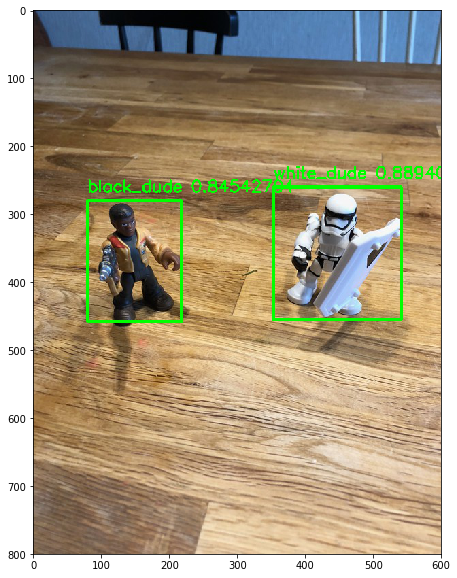

In [10]:
import cv2
import matplotlib.pyplot as plt
from utils import draw_boxes

plt.figure(figsize=(10,10))
image = cv2.imread('training/images/IMG_5899.jpg')
boxes = model.predict(image)
image = draw_boxes(image, boxes, config['model']['labels'])
plt.imshow(image[:,:,::-1]); plt.show()